 # Построение осцилляторов и индикаторов на основе акций Microsoft

## Загрузка данных из файла

In [377]:
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tulipy as ti
%matplotlib inline
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
df = joblib.load("../Documents/MSFT.pkl")
df['test'] = df['open']
df.test = df.test.shift(-1) #сдвигаю вниз
y = df['open'].values
z = df['close'].values
high = df['high'].values
low = df['low'].values
#df = df.dropna()           #удаляю первую строку
new_o = df.loc[:,['open']] #фильтр
ewma = pd.Series.ewm

## Cкользящая средняя
![SMA-1.png](img/SMA-1.png)

где SMAt – значение простого скользящего среднего в период времени t;

n – интервал сглаживания;

Pt-i – значение случайной величины на момент (t-i).

In [378]:
#скользящая средняя
def moving_average(new_o, n): 
    MA = pd.Series(new_o['open'].rolling(window=n).mean())
    return MA

## Экспоненциальное скользящее среднее
![EMA-1.png](img/EMA-1.png)

α – весовой коэффициент в интервале от 0 до 1, отражающий скорость старения прошлых данных: чем выше его значение, тем больший удельный вес имеют новые наблюдения случайной величины, и тем меньший старые;

Pt – значение случайной величины в период времени t;

EMAt-1 – значение экспоненциального скользящего среднего в период времени (t-1).

In [379]:
#Экспоненциальная скользящая средняя
def exponential_moving_average(new_o, n):
    EMA = pd.Series(new_o['open'].ewm(span=n, min_periods=n).mean())
    return EMA

## Построение графиков средних скользящих

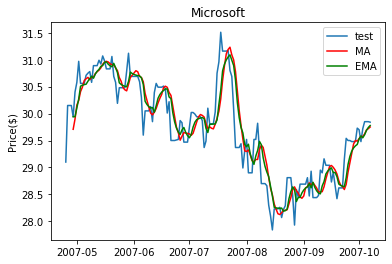

In [380]:
new_o['EMA'] = exponential_moving_average(new_o, 5)
new_o['MA'] = moving_average(new_o, 5)
df['MA'] = new_o['MA']
df['EMA'] = new_o['EMA']
df = df.loc['2007-04-25':'2007-10-07']  #фильтр для детализации
plt.plot(df.index,df['test'], label='test')
plt.plot(df.index,df['MA'],label='MA', color = 'red')
plt.plot(df.index,df['EMA'],label='EMA', color = 'green')
plt.legend()
plt.title('Microsoft')
plt.ylabel('Price($)')
plt.show()

## RSI
![RSI-formula.png](img/RSI-formula.png)

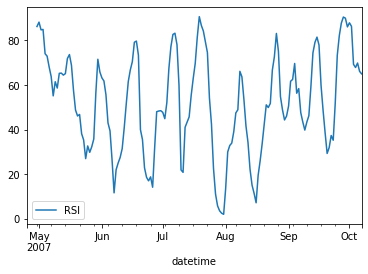

In [381]:
#RSI индикатор
def RSI(series, n):
    delta = series.diff()
   # u = delta * 0
    #d = u.copy()
   # u[delta > 0] = delta[delta > 0]
    #d[delta < 0] = -delta[delta < 0]
    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0
    RolUp = pd.Series(dUp.rolling(window=n).mean())
    RolDown = pd.Series(dDown.rolling(window=n).mean()).abs()
    #RolUp = RolUp.drop(RolUp.index[:(n-1)])
    #RolDown = RolDown.drop(RolDown.index[:(n-1)])
    RS = ewma(RolUp, span=n-1).mean() / ewma(RolDown, span=n-1).mean()
    #u[u.index[period-1]] = np.mean( u[:period] ) #сумма средних увеличений
    
    #d[d.index[period-1]] = np.mean( d[:period] ) #сумма средних уменьшений
    
    #rs = u/d
    #rs = ewma(u, span=period-1).mean() / ewma(d, span=period-1).mean()
    return 100 - 100 / (1 + RS)
new_o['RSI'] = RSI(df.close, 5) 
df['RSI'] = new_o['RSI']
df.plot(y=['RSI'])

## Стохастический осциллятор
![stochastic-1.png](img/stochastic-1.png)

где N – количество периодов;

Ct – цена закрытия в период времени t;

HN – максимальное значение цены за последние N периодов;

LN – минимальное значение цены за последние N периодов.

Формула расчета %D в период времени t представляет собой простое скользящее среднее %K с интервалом сглаживания m.

![stochastic-2.png](img/stochastic-2.png)

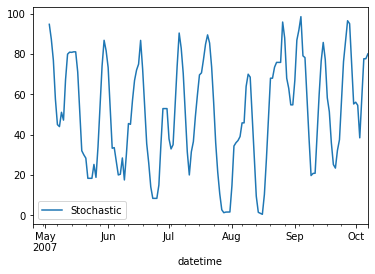

In [382]:
#Стохастик индикатор

def stochastic_oscillator(close, low, high, n):
    SOk = ((close-pd.Series(low.rolling(window = n).min())) / (pd.Series(high.rolling(window = n).max()) - pd.Series(low.rolling(window = n).min()))) * 100
    SOd = pd.Series(SOk.rolling(window = n).mean())
    return SOd
df['Stochastic'] = stochastic_oscillator(df['close'],df['low'],df['high'], 5)
df.plot(y=['Stochastic'])

## Библиотека Tulip


In [383]:
#Tulip Indicators
stoch_k, stoch_d = ti.stoch(high, low, z, 5, 3, 3)
sma = ti.sma(y, 5)
rsi = ti.rsi(z, 5)
ema = ti.ema(y,5)
print('MA: ', sma)
print('EMA: ',ema)
print('RSI: ',rsi)
print('Stochastic: ',stoch_d)

MA:  [29.708 29.898 30.158 ... 78.778 79.278 80.314]
EMA:  [28.99       29.02666667 29.40111111 ... 78.67755184 79.5383679
 81.0055786 ]
RSI:  [86.25954198 90.45092838 91.86670432 ... 79.05515358 96.30482485
 98.23583513]
Stochastic:  [93.87931034 92.42898238 82.69909537 ... 88.88888889 77.6048422
 66.3207955 ]


## Сравнение графиков

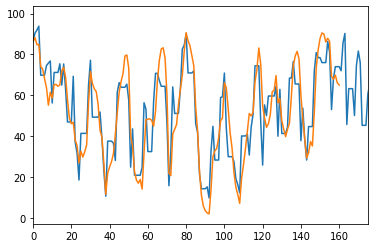

In [384]:
grafic = df['RSI'].values
grafic = grafic[np.logical_not(np.isnan(grafic))]
plt.plot(rsi)
plt.plot(grafic)
plt.xlim(0, 175)
plt.show()

## Линейная регрессия

In [385]:
import sklearn
from sklearn.linear_model import LinearRegression
a = df['MA'].values.reshape((-1,1))
b = df['test'].values
a=a[4:100]
b=b[4:100]
c=df['open'].values
c=c[4:100]
model = LinearRegression().fit(a,b)
print(model.score(a,b))
print(model.intercept_)
print(model.coef_)
b_pred = model.predict(a)
print(b[:5])
print('Predicted: ', b_pred[:5])
mse = sklearn.metrics.mean_squared_error(b, b_pred)
r2 = sklearn.metrics.r2_score(b, b_pred)
print('MSE: ', mse)
print('R2: ', r2)

0.5265676606261873
4.458635913496725
[0.85209963]
[29.94 30.4  30.58 30.97 30.56]
Predicted:  [29.77281177 29.9347107  30.1562566  30.22953717 30.36928151]
MSE:  0.1603575730850062
R2:  0.5265676606261873


In [386]:
#объединение dataframe
#b_pred = pd.DataFrame(data = b_pred, index = df.index.values, columns = ['Pred'])
#b_pred.head()

## Линейная регрессия с окнами 7, 14, 30

In [387]:
periods = 30
#periods = 14
#periods = 30
#X = np.array(df[['open']])
for i in range(1,periods):
    df[i] = df['MA'].shift(i)
    #temp = np.array(df[[i]])                 
    #X = np.concatenate((X, temp))
#df['MA1'] = df['MA'].shift(1)
#df.dropna(subset=['MA', 'MA1'])
X = np.array(df[['open','MA',1,2,3,4,5,6]])
X = X[10:]
Y = np.array(df['test'])
Y = Y[10:]
X1 = np.array(df[['open','MA',1,2,3,4,5,6,7,8,9,10,11,12,13]])
X1 = X1[17:]
Y1 = np.array(df['test'])
Y1 = Y1[17:]
X2 = np.array(df[['open','MA',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])
X2 = X2[33:]
Y2 = np.array(df['test'])
Y2 = Y2[33:]
lr = LinearRegression().fit(X,Y)
Y_pred = lr.predict(X)
lr1 = LinearRegression().fit(X1,Y1)
Y1_pred = lr1.predict(X1)
lr2 = LinearRegression().fit(X2,Y2)
Y2_pred = lr2.predict(X2)
print('R^2, window=7: ', lr.score(X,Y)) # R^2
print('Predicted first 5 values:', Y_pred[:5], sep='\n')
print('R^2, window=14: ', lr1.score(X1,Y1))
print('Predicted first 5 values:', Y1_pred[:5], sep='\n')
print('R^2, window=30: ', lr2.score(X2,Y2))
print('Predicted first 5 values:', Y2_pred[:5], sep='\n')

R^2, window=7:  0.9122049196996982
Predicted first 5 values:
[30.4993392  30.42298742 30.66434868 30.62151623 30.69673862]
R^2, window=14:  0.9143557247471834
Predicted first 5 values:
[30.81442277 30.81420368 30.92951786 30.96351323 30.9662909 ]
R^2, window=30:  0.908521721903851
Predicted first 5 values:
[30.36485044 30.86420322 30.96527547 30.73793014 30.4769495 ]


In [388]:
new_o

,open,EMA,MA,RSI
datetime,,,,
2007-04-25,28.99,NaN,NaN,NaN
2007-04-26,29.10,NaN,NaN,NaN
2007-04-27,30.15,NaN,NaN,NaN
2007-04-28,30.15,NaN,NaN,NaN
2007-04-29,30.15,29.942607,29.708,NaN
2007-04-30,29.94,29.941654,29.898,86.259542
2007-05-01,30.40,30.103934,30.158,88.225675
2007-05-02,30.58,30.269066,30.244,84.777356
2007-05-03,30.97,30.508950,30.408,84.938629


In [389]:
df

,open,high,low,close,vol0,vol1,datetime,assetCode,test,MA,...,20,21,22,23,24,25,26,27,28,29
datetime,,,,,,,,,,,,,,,,,,,,,
2007-04-25,28.99,28.9900,28.9900,28.9900,5556.0,38064896.0,2007-04-25 16:02:00,MSFT_1,29.10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-26,29.10,29.1100,29.1000,29.1000,1084750.0,57165056.0,2007-04-26 16:01:00,MSFT_1,30.15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-27,30.15,30.1500,30.1200,30.1200,1111878.0,125368502.0,2007-04-27 16:01:00,MSFT_1,30.15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-28,30.15,30.1500,30.1200,30.1200,1111878.0,125368502.0,2007-04-27 16:01:00,MSFT_1,30.15,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-29,30.15,30.1500,30.1200,30.1200,1111878.0,125368502.0,2007-04-27 16:01:00,MSFT_1,29.94,29.708,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-04-30,29.94,29.9500,29.9400,29.9400,2001071.0,62792593.0,2007-04-30 16:01:00,MSFT_1,30.40,29.898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-01,30.40,30.4200,30.4000,30.4000,1126750.0,69829805.0,2007-05-01 16:01:00,MSFT_1,30.58,30.158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-02,30.58,30.6100,30.5800,30.6100,1273233.0,71197735.0,2007-05-02 16:01:00,MSFT_1,30.97,30.244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-05-03,30.97,30.9700,30.9700,30.9700,1104358.0,80155642.0,2007-05-03 16:01:00,MSFT_1,30.56,30.408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
